In [1]:
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import muon as mu
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib as mpl
from collections import Counter
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter, PercentFormatter
import omicverse as ov
mpl.rcParams['font.family'] = 'Arial'
figPath = "NKTCL-figure-2.18"
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.size"] = 14

In [2]:
sc.settings.set_figure_params(dpi_save=300)

In [2]:
adata_Mye = sc.read_h5ad("/data/hanxue/hanxue_data/adata-xwt-annotated-Mye1.h5ad")

In [3]:
adata_Mye

AnnData object with n_obs × n_vars = 12990 × 41733
    obs: 'batch', 'mt_frac', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'leiden', 'major_type', 'molecular_type', 'leiden_harmony', 'major_type_harmony', 'minor_type', 'minor-type', 'gender', 'doublet_score', 'predicted_doublet', 'leiden-harmony-female', 'majorType-Female', 'epi-subtype', 'treat', 'leiden-1', 'annotation', 'leiden-Mye', 'Groups', 'groups', 'anno-Mye', 'anno-Mye1'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'anno-Mye1_colors', 'anno-Mye_colors', 'annotation_colors', 'batch_colors', 'dendrogram_anno-Mye', 'dendrogram_annotation', 'dendrogram_leiden', 'dendrogram_leiden-1', 'dendrogram_leiden-Mye', 'gender_colors', 'hvg', 'leiden', 'leiden-1_colors', 'leiden-Mye_colors', 'leiden-harmony-female

In [5]:
list(adata_Mye.obs['anno-Mye1'].unique())

['M09_cDC2',
 'M03_Mac3_FOLR2',
 'M12_cycling',
 'M06_Monocyte',
 'M02_Mac2_CXCL9',
 'M01_Mac1_SPP1',
 'M04_Mac4_C3',
 'M10_LC',
 'M05_Mac5_MMP9',
 'M11_mDC',
 'M08_cDC1',
 'M07_Neutrophil']

/tmp/ipykernel_3059749/1319698820.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_counts = adata_Mye.obs.groupby(['batch', 'anno-Mye1']).size().unstack(fill_value=0)


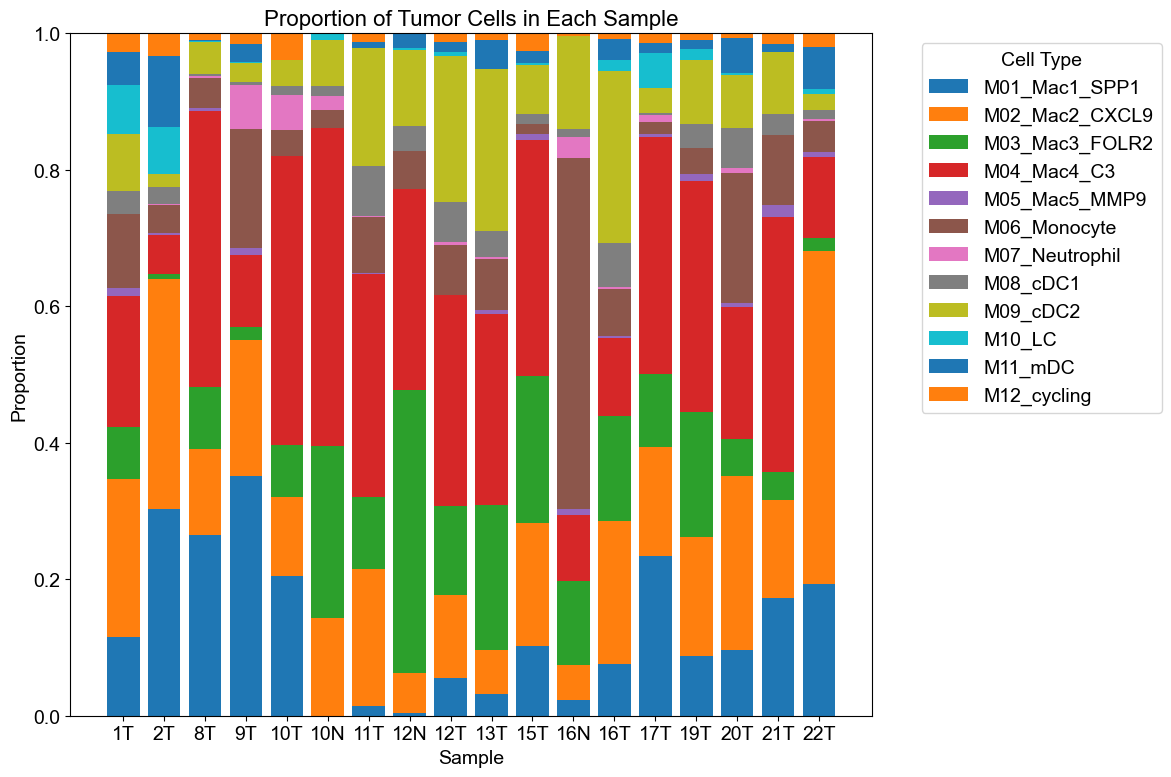

In [5]:
# 1. 计算每个样本中每种细胞类型的数量
cell_type_counts = adata_Mye.obs.groupby(['batch', 'anno-Mye1']).size().unstack(fill_value=0)

# 2. 计算每个样本的总细胞数
sample_totals = cell_type_counts.sum(axis=1)

# 3. 计算每种细胞类型在每个样本中的占比
proportions = cell_type_counts.div(sample_totals, axis=0)

# 4. 绘制堆叠条形图
fig, ax = plt.subplots(figsize=(12, 8))

# 遍历每个细胞类型，逐层堆叠
bottom = np.zeros(len(cell_type_counts.index))  # 初始化底部高度
for cell_type in proportions.columns:
    ax.bar(proportions.index, proportions[cell_type], bottom=bottom, label=cell_type)
    bottom += proportions[cell_type]  # 更新底部高度

# 添加标题和标签
ax.set_title('Proportion of Tumor Cells in Each Sample', fontsize=16)
ax.set_xlabel('Sample', fontsize=14)
ax.set_ylabel('Proportion', fontsize=14)
ax.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# 显示图形
plt.tight_layout()
plt.show()

In [3]:
def MergeSubAdata(adata, subAdata, obsName, subObsName):
    obs = pd.Series(list(adata.obs[obsName].copy()), index=adata.obs_names)
    subObs = pd.Series(list(subAdata.obs[subObsName].copy()), index=subAdata.obs_names)
    obs.loc[subObs.index] = subObs
    return pd.DataFrame(obs, columns=[obsName])

def marker(adata, groupby, method='wilcoxon', prefix=''):
    sc.tl.rank_genes_groups(adata, groupby = groupby, method = method)
    sc.tl.dendrogram(adata, groupby=groupby, use_rep='X_pca_harmony')
    sc.pl.rank_genes_groups_dotplot(adata, groupby = groupby, save=prefix+groupby+'.svg')
    return adata

def clu(adata, key_added="majorType-fix", n_neighbors=50, n_pcs=30, rep='X_pca_harmony', do_har=False, max_iter=20, do_scrublet=False, har_key='batch', resolution=1):
    # Computing the neighborhood graph
    if do_scrublet:
        n0 = adata.shape[0]
        print("{0} Cell number: {1}".format(key_added, n0))
        sc.external.pp.scrublet(adata)
        adata = adata[adata.obs['predicted_doublet']==False,:].copy()
        print("{0} Cells retained after scrublet, {1} cells reomved.".format(adata.shape[0], n0-adata.shape[0]))
    else:
        print("Ignoring processing doublet cells...")
    if do_har and len(adata.obs[har_key].cat.categories) > 1:
        sc.external.pp.harmony_integrate(adata, key=har_key,max_iter_harmony=max_iter)
        sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, use_rep=rep)
    else:
        print("Evaluating neighbors only...")
        sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, use_rep=rep)
    # Run UMAP
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=resolution, key_added=key_added)
    sc.pl.umap(adata, color=key_added, legend_fontoutline=True, palette=sc.pl.palettes.default_20, legend_loc="on data")
    return adata

In [5]:
def propPlot(age_df, barlabels1, barlabels2, ax, colors=sc.pl.palettes.default_20, xlabel='Sample ID', show_y=True, xrotate=90):
    all_df = age_df.sum(axis=1)
    age_normdf = pd.DataFrame([age_df.loc[i,:]/all_df[i] for i in barlabels1], index=barlabels1)
    age_cumdf = pd.DataFrame([np.cumsum(age_normdf.loc[i,:]) for i in barlabels1], index=barlabels1)
    norm_gdfs = age_normdf
    cum_gdfs = age_cumdf
    for i, col in enumerate(age_df.columns):
        height = norm_gdfs[col]
        starts = cum_gdfs[col] - height
        rects = ax.bar(barlabels2, height, bottom=starts, width=0.9, color=colors[i], edgecolor='white', linewidth=0.5,
                        label=col, alpha=1)
    
        # ax.bar_label(rects,age_df.loc[:, col], label_type='center', color='lightgrey', fontsize=14)
    ax.legend( bbox_to_anchor=(1, -0.3), 
              handletextpad=0.5, frameon=False,
                          borderpad=0.4,
                          columnspacing=1,
                          handlelength=0.65,
              loc='lower left', fontsize=14)
    if show_y:
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
        ax.set_ylabel('Cell proportions')
    else:
        ax.yaxis.set_visible(False)
        ax.spines.left.set_visible(False)
    ax.set_xlabel(xlabel)
    ax.set_xticks(barlabels2)
    ax.set_xticklabels(labels=barlabels2,rotation=xrotate,fontsize=13)
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
 # 关闭背景网格线
    ax.grid(False)  

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

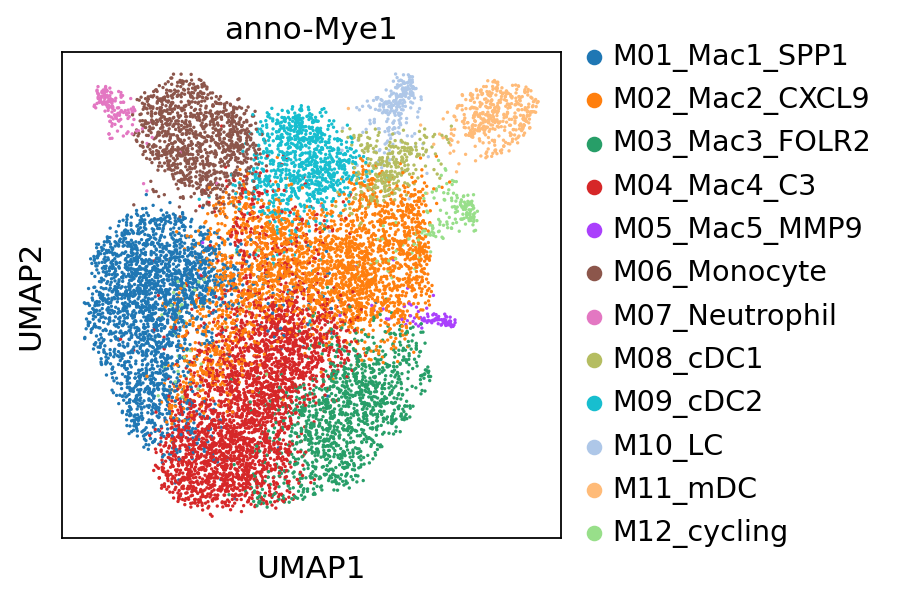

In [6]:
sc.pl.umap(adata_Mye, color="anno-Mye1",  palette=sc.pl.palettes.default_20, save='-myeloid.svg')

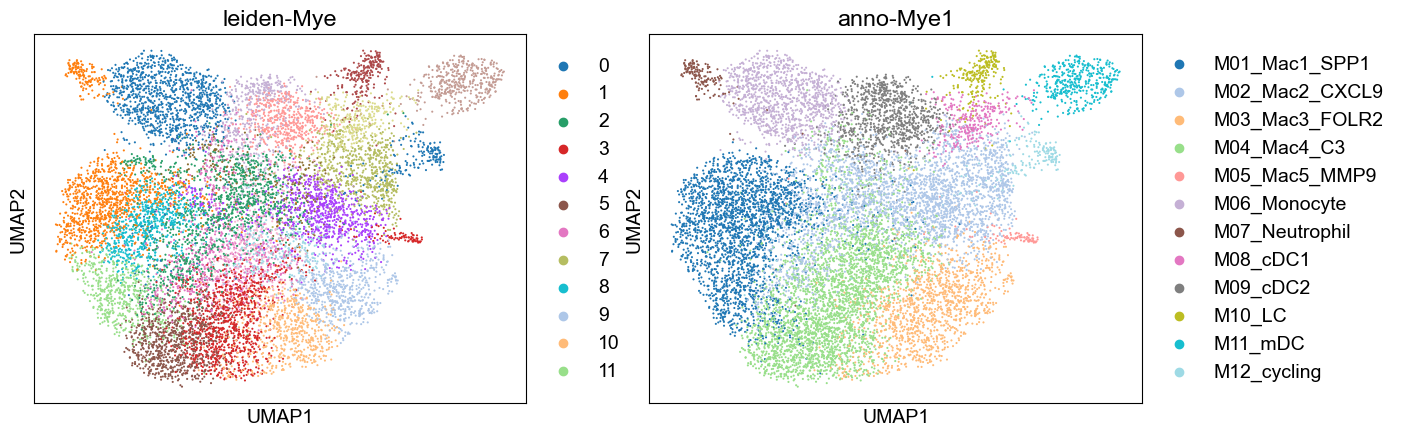

In [10]:
sc.pl.umap(adata_Mye, color= ['leiden-Mye', 'anno-Mye1'])

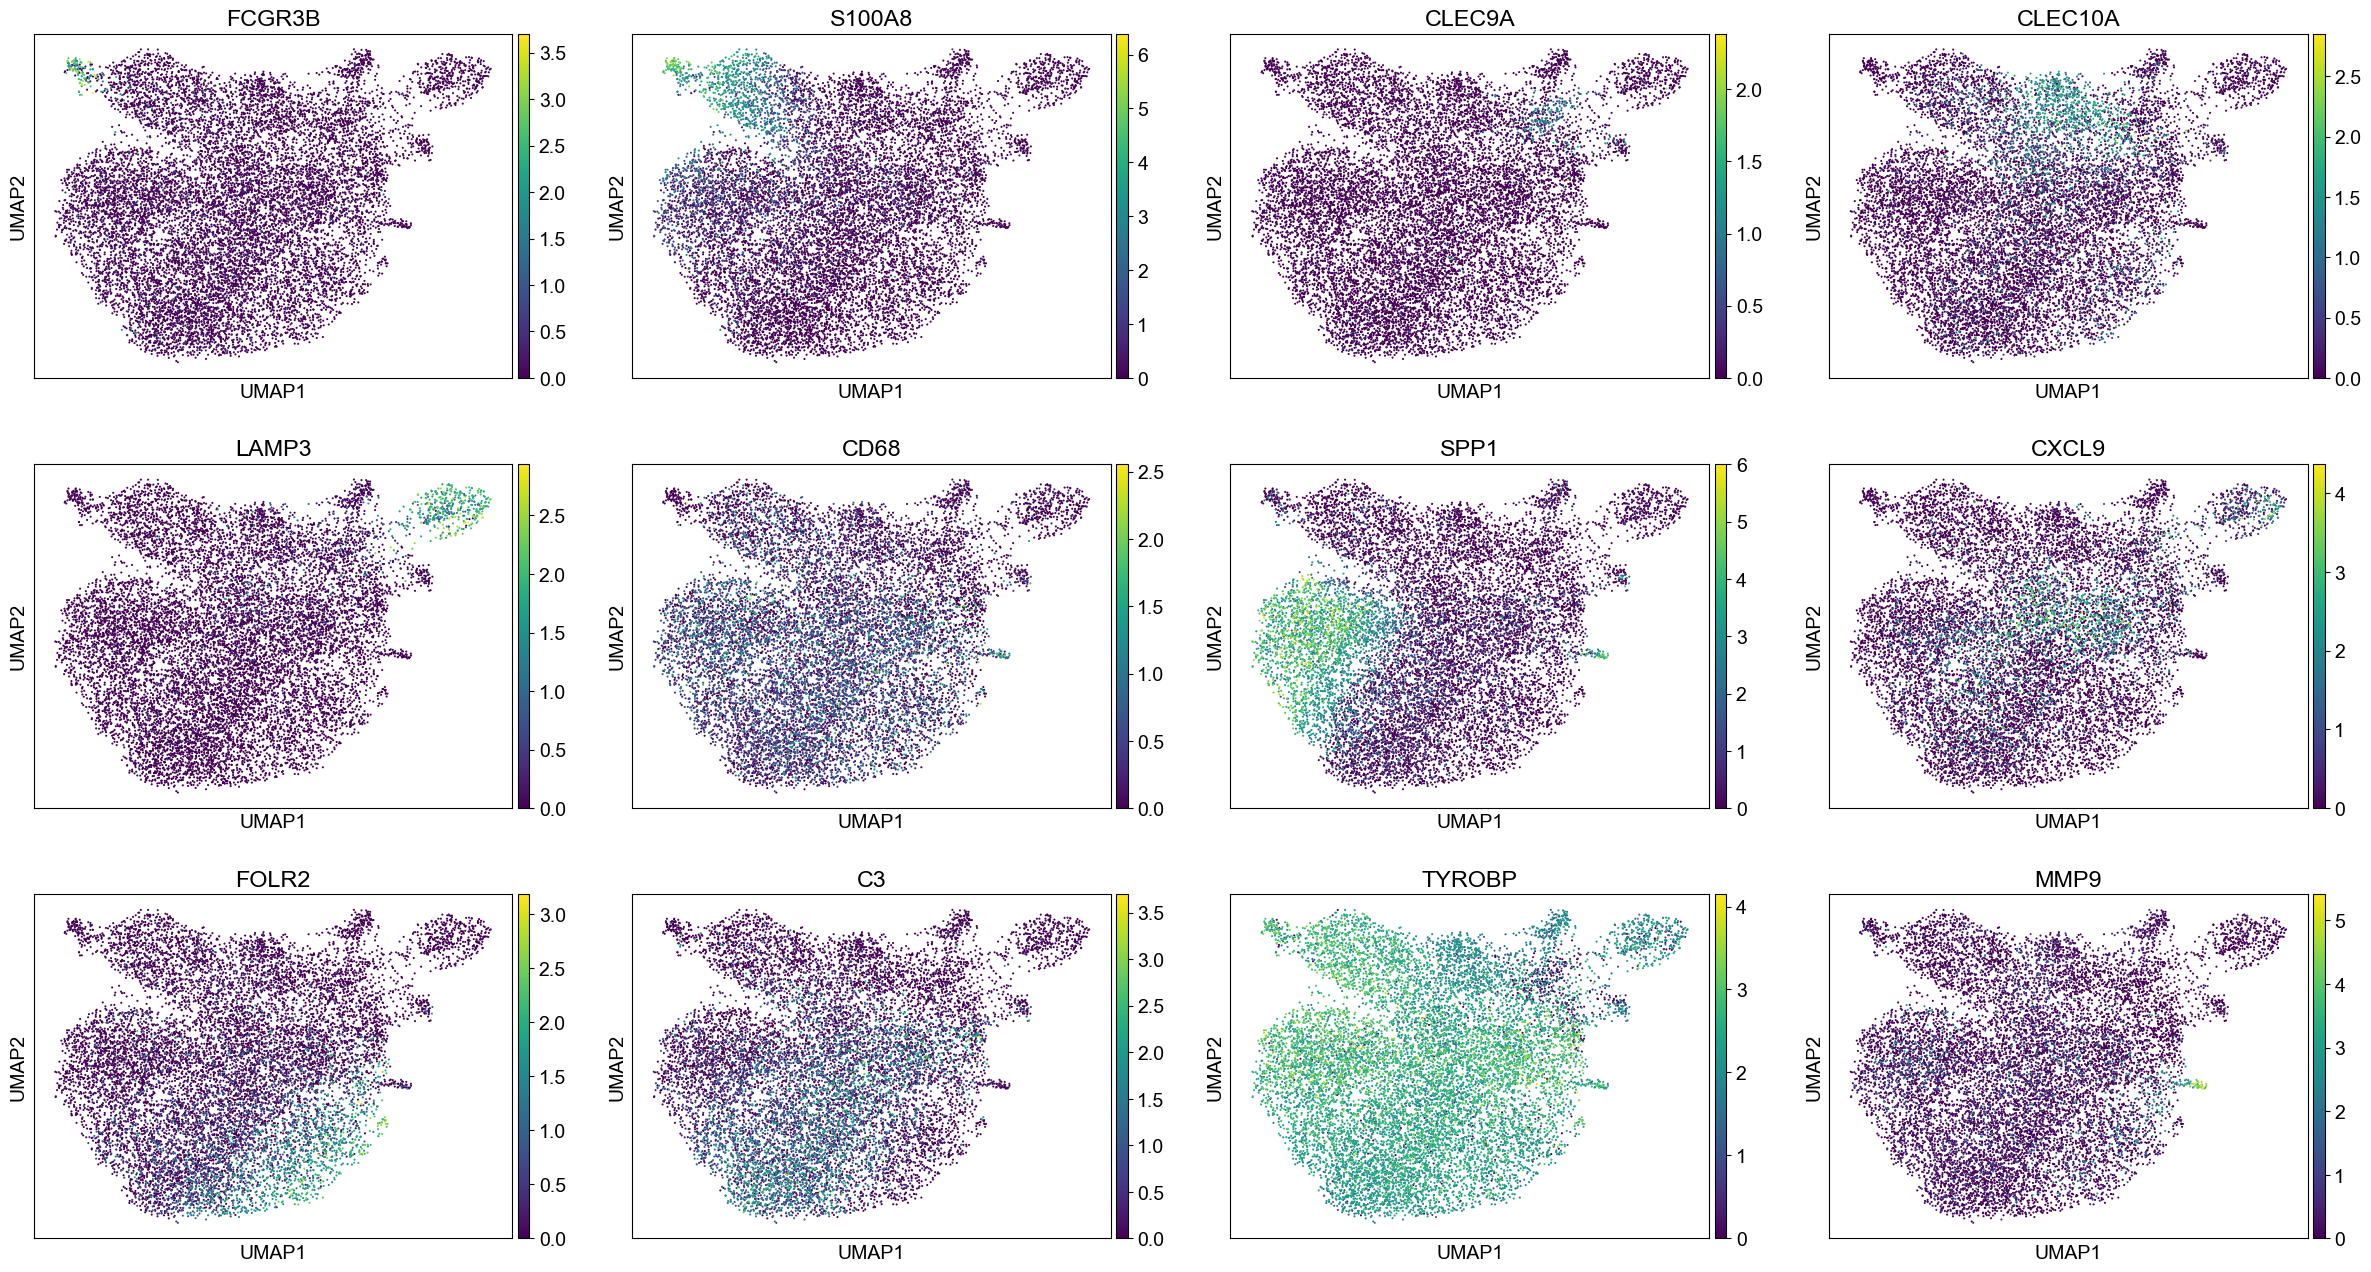

In [8]:
sc.pl.umap(adata_Mye, color=['FCGR3B',  # Neutrophil
                            'S100A8',  # Monocyte
                            'CLEC9A',  # cDC1
                            'CLEC10A',  # cDC2
                            'LAMP3',   # mDC
                            'CD68',    # Macro
                            'SPP1',  
                            'CXCL9',  
                            'FOLR2',
                            'C3',
                            'TYROBP',  # Myeloid
                            'MMP9'
                           ])

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

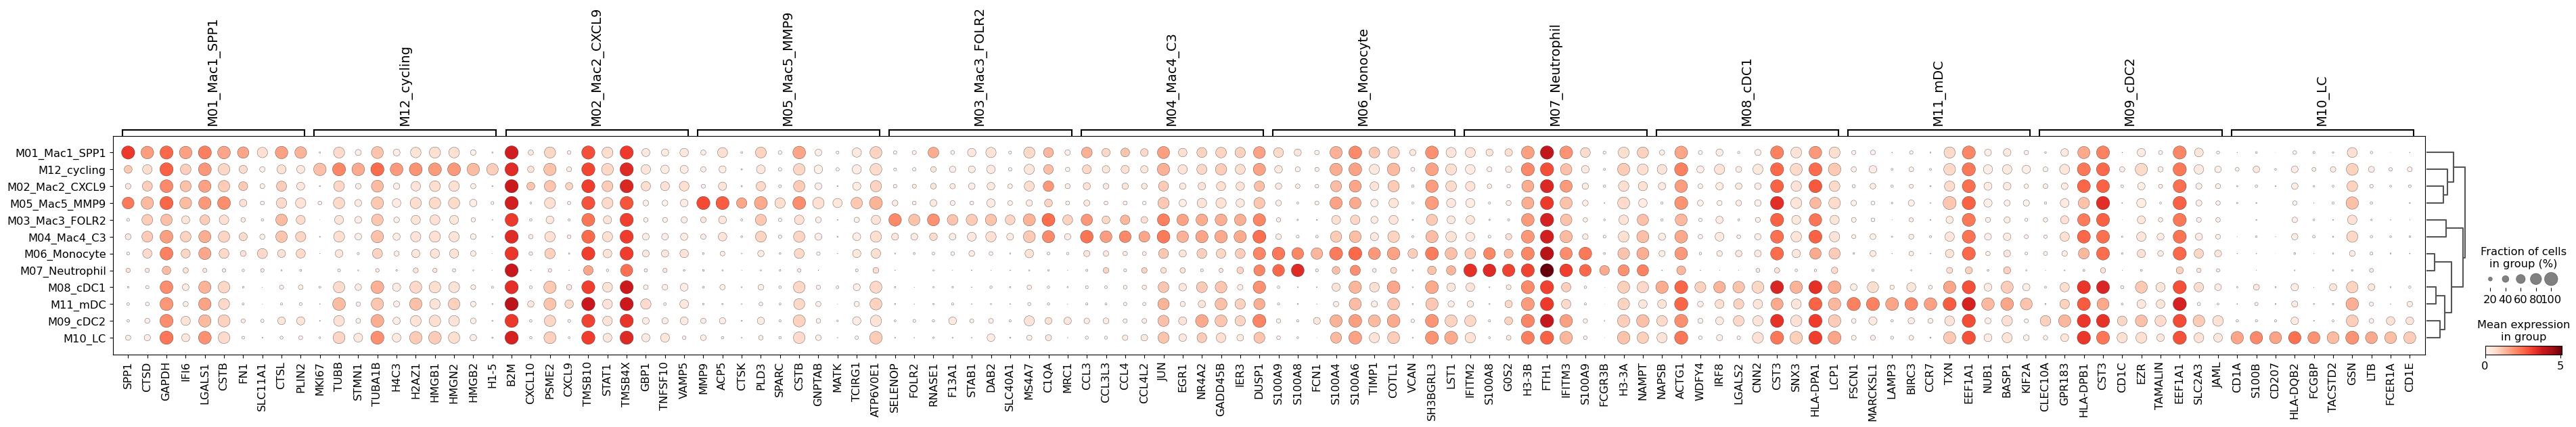

In [4]:
sc.tl.rank_genes_groups(adata_Mye, groupby = "anno-Mye1", method = "wilcoxon")
sc.tl.dendrogram(adata_Mye, groupby="anno-Mye1", use_rep='X_pca_harmony')
sc.pl.rank_genes_groups_dotplot(adata_Mye, groupby = "anno-Mye1")

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

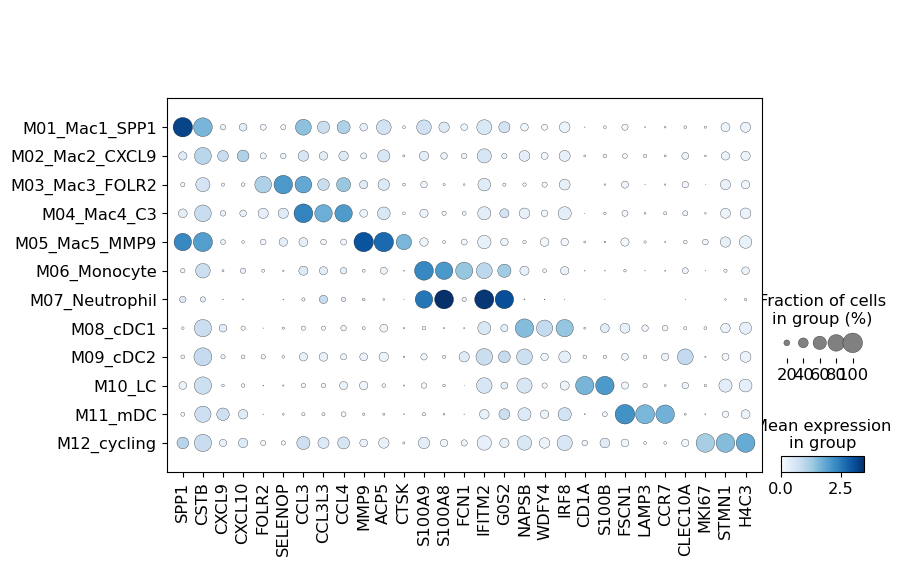

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

In [12]:
fig, ax = plt.subplots(1,1,figsize=(9,6))
sc.pl.dotplot(adata_Mye, groupby='anno-Mye1',  cmap='Blues', var_names=[
    "SPP1", "CSTB",
    'CXCL9', 'CXCL10',
    'FOLR2', 'SELENOP',
    'CCL3', 'CCL3L3', 'CCL4', 
    'MMP9', 'ACP5', 'CTSK',
    'S100A9', 'S100A8', 'FCN1',
    'IFITM2', 'G0S2', 
    'NAPSB', 'WDFY4', 'IRF8', 
    'CD1A', 'S100B',
    'FSCN1', 'LAMP3', 'CCR7',
    'CLEC10A',  "MKI67", "STMN1", 'H4C3'], ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
fig.savefig("figures/Myeloid-variables.svg", bbox_inches='tight')

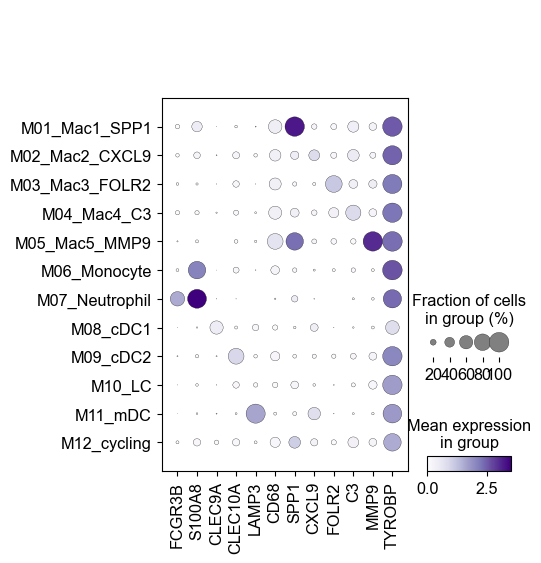

In [10]:
fig, ax = plt.subplots(1,1,figsize=(4.5,6))
sc.pl.dotplot(adata_Mye, groupby='anno-Mye1',  cmap='Purples', var_names=[
 'FCGR3B','S100A8','CLEC9A', 'CLEC10A', 'LAMP3', 'CD68',  'SPP1', 'CXCL9',  'FOLR2','C3', 'MMP9', 'TYROBP'], ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
fig.savefig("figures/Myeloid-markers.svg", bbox_inches='tight')

In [14]:
adata_ab = adata_Mye[adata_Mye.obs['treat'].isin(['After', 'Before']), :]

In [17]:
list(adata_Mye.obs['anno-Mye1'].unique())

['M09_cDC2',
 'M03_Mac3_FOLR2',
 'M12_cycling',
 'M06_Monocyte',
 'M02_Mac2_CXCL9',
 'M01_Mac1_SPP1',
 'M04_Mac4_C3',
 'M10_LC',
 'M05_Mac5_MMP9',
 'M11_mDC',
 'M08_cDC1',
 'M07_Neutrophil']

In [16]:
from collections import Counter
def propByCell(adata, group, key, batch):
    groups = adata.obs[batch][adata.obs[group]==key]
    props = Counter(groups)
    all = sum(props.values())
    for item in props.keys():
        props[item] = (props[item] / all)
    return props

def propByBatch(adata, group, key, batch):
    groups = adata.obs[batch][adata.obs[group]==key]
    props = Counter(groups)
    for item in props.keys():
        props[item] = (props[item] / sum(adata.obs[batch]==item))
    return props


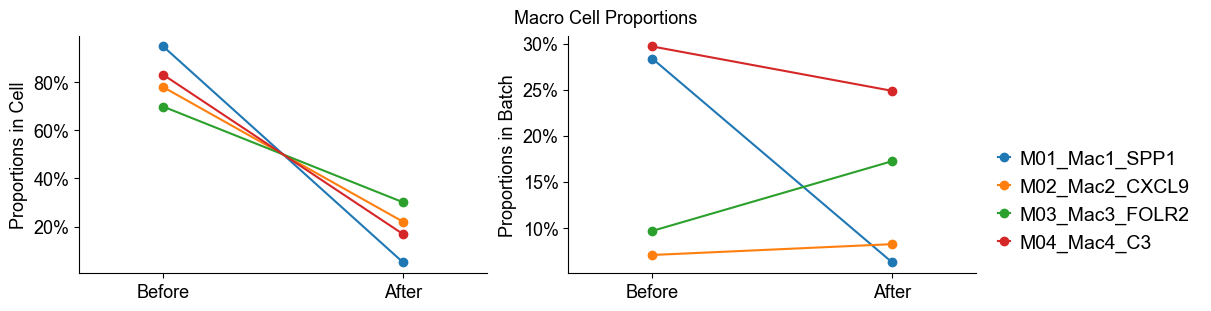

In [18]:
import matplotlib.pyplot as plt
from matplotlib import ticker
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.size"] = 13

def propPlot(adata, ax, group, keys, diff, mode='Cell', showLegend=True):
    if mode=='Cell':
        fn=propByCell
    else:
        fn=propByBatch
    for key in keys:
        props = fn(adata, group, key, diff)
        y=list(props.values())
        x=list(props.keys())
        ax.plot(x, y, marker='o', label=key)
        bar=list(props.keys())
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
    ax.set_ylabel('Proportions in {}'.format(mode))
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.set_xlim(-0.35,1.35)
    if showLegend:
        ax.legend( bbox_to_anchor=(1, 0), 
              handletextpad=0.5, frameon=False,
                          borderpad=0.6,
                          columnspacing=1.3,
                          handlelength=0.65,
              loc='lower left', fontsize=14)
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12, 3),constrained_layout=True)
propPlot(adata_ab, ax[0], 'anno-Mye', 
         ['M01_Mac1_SPP1', 'M02_Mac2_CXCL9', 'M03_Mac3_FOLR2', 'M04_Mac4_C3', 'M05_Mac5_MMP9'], 'treat', showLegend=False)
propPlot(adata_ab, ax[1], 'anno-Mye', ['M01_Mac1_SPP1', 'M02_Mac2_CXCL9', 'M03_Mac3_FOLR2', 'M04_Mac4_C3'], 'treat', mode="Batch")
fig.suptitle("Macro Cell Proportions", fontsize=13)
fig.show()
fig.savefig("figures/Myeloid-Cell-prop-plot.svg", bbox_inches='tight')

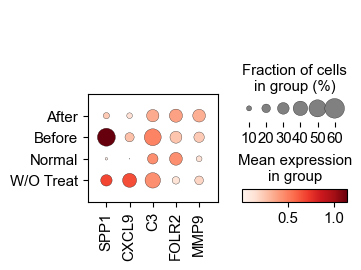

In [19]:
sc.pl.dotplot(adata_Mye, var_names = ['SPP1', 'CXCL9', 'C3', 'FOLR2', 'MMP9'], groupby='treat' )

[Text(0, 0, 'After'),
 Text(1, 0, 'Before'),
 Text(2, 0, 'Normal'),
 Text(3, 0, 'W/O Treat')]

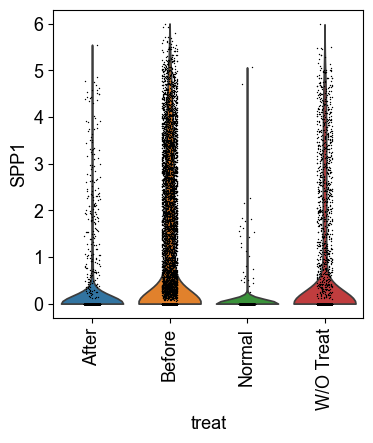

In [20]:
fig, ax = plt.subplots(figsize=(4, 4))
sc.pl.violin(adata_Mye, keys=['SPP1'], groupby='treat', ax=ax, show=False)
ax.set_xticklabels(adata_Mye.obs['treat'].cat.categories, rotation=90)

[Text(0, 0, 'After'),
 Text(1, 0, 'Before'),
 Text(2, 0, 'Normal'),
 Text(3, 0, 'W/O Treat')]

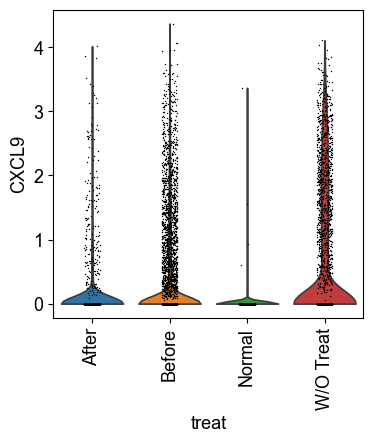

In [21]:
fig, ax = plt.subplots(figsize=(4, 4))
sc.pl.violin(adata_Mye, keys=['CXCL9'], groupby='treat', ax=ax, show=False)
ax.set_xticklabels(adata_Mye.obs['treat'].cat.categories, rotation=90)

[Text(0, 0, 'After'),
 Text(1, 0, 'Before'),
 Text(2, 0, 'Normal'),
 Text(3, 0, 'W/O Treat')]

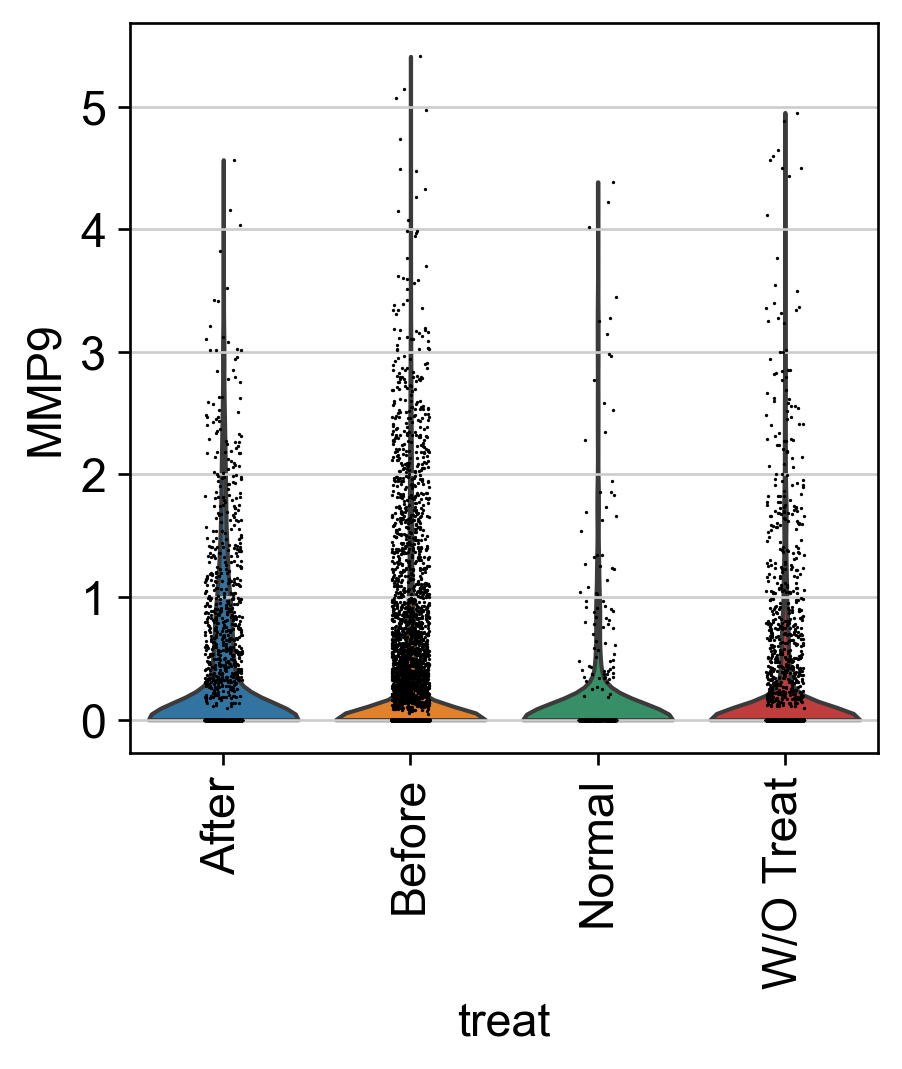

In [25]:
fig, ax = plt.subplots(figsize=(4, 4))
sc.pl.violin(adata_Mye, keys=['MMP9'], groupby='treat', ax=ax, show=False)
ax.set_xticklabels(adata_Mye.obs['treat'].cat.categories, rotation=90)

In [4]:
use_raw = adata_Mye.raw is not None
use_raw 

False

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

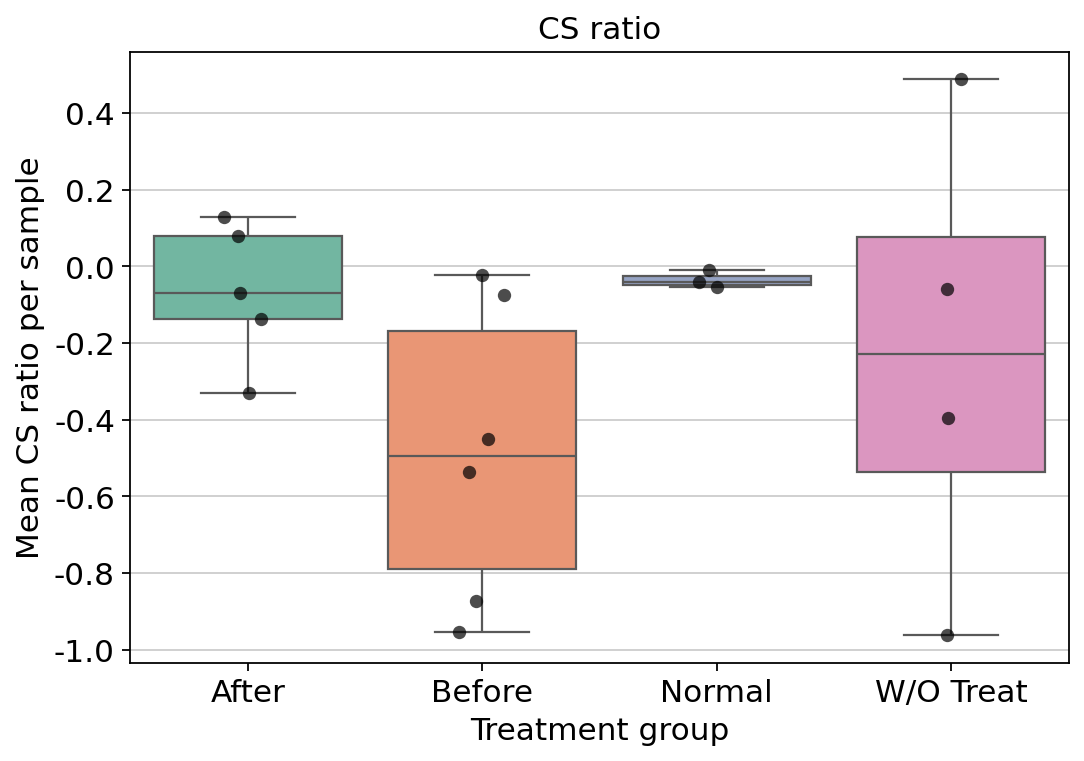

In [11]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 读取数据
adata = sc.read_h5ad("/data/hanxue/hanxue_data/adata-xwt-annotated-Mye1.h5ad")

# 2. 确认基因存放位置（优先用 adata.raw）
use_raw = adata.raw is not None
genes = adata.raw.var_names if use_raw else adata.var_names

for g in ["CXCL9", "SPP1"]:
    if g not in genes:
        raise ValueError(f"{g} not found in adata")

# 3. 提取 CXCL9 和 SPP1 表达量
if use_raw:
    cxcl9_exp = adata.raw[:, "CXCL9"].X
    spp1_exp  = adata.raw[:, "SPP1"].X
else:
    cxcl9_exp = adata[:, "CXCL9"].X
    spp1_exp  = adata[:, "SPP1"].X

# 转换为一维向量（避免稀疏矩阵影响）
if hasattr(cxcl9_exp, "toarray"):
    cxcl9_exp = cxcl9_exp.toarray().flatten()
    spp1_exp  = spp1_exp.toarray().flatten()
else:
    cxcl9_exp = np.array(cxcl9_exp).flatten()
    spp1_exp  = np.array(spp1_exp).flatten()

# 4. 计算 CS ratio (log 差值方式)
adata.obs["CS_ratio"] = np.log2(cxcl9_exp + 1) - np.log2(spp1_exp + 1)

# 5. 按 sample_id 计算每个样本的平均 CS ratio
# ⚠️ 请确认你有 adata.obs['sample_id']，如果列名不同，请修改这里
df = adata.obs.groupby(["batch", "treat"])["CS_ratio"].mean().reset_index()

# 6. 绘制箱线图（每个点是一个样本）
plt.figure(figsize=(7,5))
sns.boxplot(x="treat", y="CS_ratio", data=df, palette="Set2")
sns.stripplot(x="treat", y="CS_ratio", data=df, color="black", size=6, alpha=0.7)

plt.ylabel("Mean CS ratio per sample")
plt.xlabel("Treatment group")
plt.title("CS ratio")

plt.tight_layout()
plt.savefig("figures/CS_ratio_treatment_sample_level.svg", format="svg", dpi=300)
plt.show()
plt.close()


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


Kruskal-Wallis H=nan, p=nan

Dunn’s test results (FDR corrected):
               After    Before    Normal  W/O Treat
After      1.000000  0.909707  0.909707   0.909707
Before     0.909707  1.000000  0.909707   0.909707
Normal     0.909707  0.909707  1.000000   0.909707
W/O Treat  0.909707  0.909707  0.909707   1.000000
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

After vs. Before: Custom statistical test, P_val:9.097e-01


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

Before vs. Normal: Custom statistical test, P_val:9.097e-01
Normal vs. W/O Treat: Custom statistical test, P_val:9.097e-01
After vs. Normal: Custom statistical test, P_val:9.097e-01
Before vs. W/O Treat: Custom statistical test, P_val:9.097e-01


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

After vs. W/O Treat: Custom statistical test, P_val:9.097e-01


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

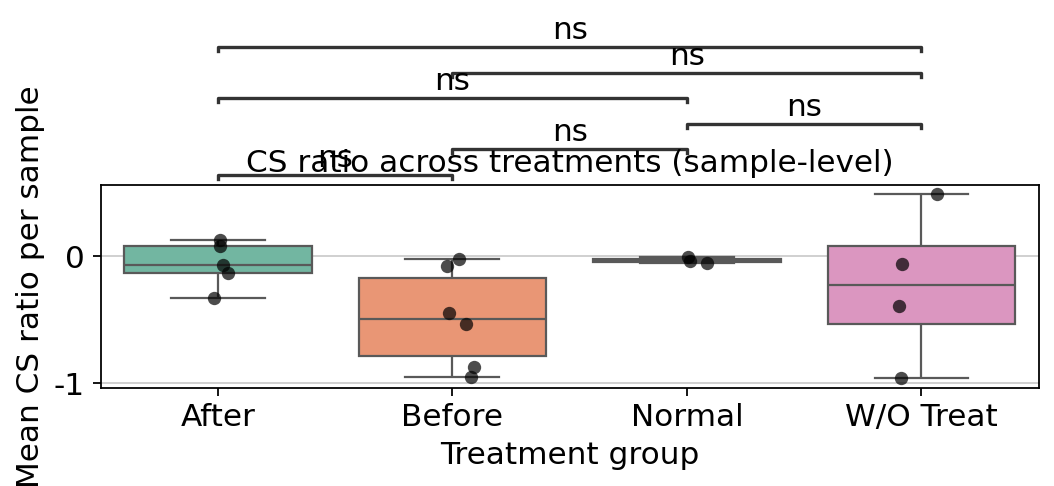

In [8]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal
import scikit_posthocs as sp
from statannotations.Annotator import Annotator

# 1. 读取数据
adata = sc.read_h5ad("/data/hanxue/hanxue_data/adata-xwt-annotated-Mye1.h5ad")

# 2. 提取 CXCL9 / SPP1 表达
use_raw = adata.raw is not None
genes = adata.raw.var_names if use_raw else adata.var_names
for g in ["CXCL9", "SPP1"]:
    if g not in genes:
        raise ValueError(f"{g} not found in adata")

if use_raw:
    cxcl9_exp = adata.raw[:, "CXCL9"].X
    spp1_exp  = adata.raw[:, "SPP1"].X
else:
    cxcl9_exp = adata[:, "CXCL9"].X
    spp1_exp  = adata[:, "SPP1"].X

if hasattr(cxcl9_exp, "toarray"):
    cxcl9_exp = cxcl9_exp.toarray().flatten()
    spp1_exp  = spp1_exp.toarray().flatten()
else:
    cxcl9_exp = np.array(cxcl9_exp).flatten()
    spp1_exp  = np.array(spp1_exp).flatten()

adata.obs["CS_ratio"] = np.log2(cxcl9_exp + 1) - np.log2(spp1_exp + 1)

# 3. 样本级平均
# ⚠️ 请确认 sample_id 列存在
df = adata.obs.groupby(["batch", "treat"])["CS_ratio"].mean().reset_index()

# 4. Kruskal-Wallis 检验（整体组间差异）
groups = [df.loc[df["treat"] == g, "CS_ratio"] for g in df["treat"].unique()]
kw_stat, kw_p = kruskal(*groups)
print(f"Kruskal-Wallis H={kw_stat:.3f}, p={kw_p:.3e}")

# 5. Dunn’s test 两两比较 + FDR 校正
posthoc = sp.posthoc_dunn(df, val_col="CS_ratio", group_col="treat", p_adjust="fdr_bh")
print("\nDunn’s test results (FDR corrected):\n", posthoc)

# 6. 绘图 + 显著性标注
plt.figure(figsize=(7,5))
ax = sns.boxplot(x="treat", y="CS_ratio", data=df, palette="Set2")
sns.stripplot(x="treat", y="CS_ratio", data=df, color="black", size=6, alpha=0.7)

# 设置比较组（根据你的需要选择，以下示例所有两两组合）
pairs = [(g1, g2) for i, g1 in enumerate(df["treat"].unique()) for g2 in df["treat"].unique()[i+1:]]

annotator = Annotator(ax, pairs, data=df, x="treat", y="CS_ratio")
annotator.configure(test=None, text_format="star", loc="outside")
annotator.set_pvalues([posthoc.loc[p[0], p[1]] for p in pairs])
annotator.annotate()

plt.ylabel("Mean CS ratio per sample")
plt.xlabel("Treatment group")
plt.title("CS ratio across treatments (sample-level)")
plt.tight_layout()
plt.savefig("CS_ratio_treatment_sample_level_stats.svg", format="svg", dpi=300)
plt.show()
plt.close()


/tmp/ipykernel_953738/2765622946.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='treat', y='CS_ratio', data=df, palette='Set3')


([0, 1, 2, 3],
 [Text(0, 0, 'After'),
  Text(1, 0, 'Before'),
  Text(2, 0, 'Normal'),
  Text(3, 0, 'W/O Treat')])

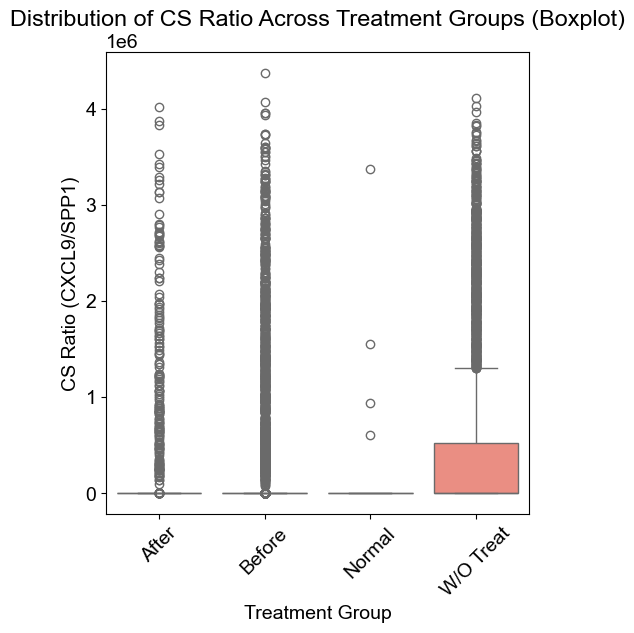

In [11]:
# 提取数据
df = adata_Mye.obs[['CS_ratio', 'treat']].copy()

# Visualization: Boxplot + Violin plot
plt.figure(figsize=(12, 6))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='treat', y='CS_ratio', data=df, palette='Set3')
plt.title('Distribution of CS Ratio Across Treatment Groups (Boxplot)')
plt.xlabel('Treatment Group')
plt.ylabel('CS Ratio (CXCL9/SPP1)')
plt.xticks(rotation=45)


In [4]:
import omicverse as ov

In [5]:
# 选用高变基因
adata_Mye_highvar = adata_Mye[:, adata_Mye.var['highly_variable']].copy()
dds = ov.bulk.pyDEG(adata_Mye_highvar.to_df().T)
dds.drop_duplicates_index()
better_groups = adata_Mye_highvar.obs[adata_Mye_highvar.obs['treat']=='After'].index.tolist() # 实验组
worse_groups = adata_Mye_highvar.obs[adata_Mye_highvar.obs['treat']=='Before'].index.tolist() # 对照组
deg_result = dds.deg_analysis(better_groups, worse_groups, method='ttest')
dds.foldchange_set(fc_threshold=-1,
                   pval_threshold=0.05,
                   logp_max=10)

⚙️ You are using ttest method for differential expression analysis.
⏰ Start to calculate qvalue...
✅ Differential expression analysis completed.
... Fold change threshold: 1.7519965171813965


In [6]:
deg_result_filter = deg_result[deg_result['sig'] != 'normal']
deg_result_filter

pvalue        qvalue  FoldChange  MaxBaseMean  \
name                                                                   
SPP1             0.000000e+00  0.000000e+00    0.207206     1.148246   
FN1              0.000000e+00  0.000000e+00    0.221035     1.075986   
S100A8           6.333869e-43  1.526234e-41    0.296271     0.430778   
IFIT3            0.000000e+00  0.000000e+00    0.209357     0.323795   
IFIT1            0.000000e+00  0.000000e+00    0.216396     0.233525   
...                       ...           ...         ...          ...   
TRIM63           4.130549e-04  2.327070e-03   58.792007     0.001707   
YIPF7            9.837972e-03  3.974938e-02   32.010635     0.001242   
ENSG00000213862  1.959721e-03  9.392751e-03   60.626583     0.001400   
LAMA4-AS1        5.553516e-04  3.043023e-03  137.442566     0.000419   
NPY2R            5.047452e-03  2.194544e-02  380.991730     0.001167   

                 BaseMean  log2(BaseMean)    log2FC  abs(log2FC)       size  \
name                                                                          
SPP1             0.693084       -0.528899 -2.270861     2.270861   0.020721   
FN1              0.656907       -0.606239 -2.177656     2.177656   0.022103   
S100A8           0.279201       -1.840623 -1.755010     1.755010   0.029627   
IFIT3            0.195791       -2.352614 -2.255963     2.255963   0.020936   
IFIT1            0.142028       -2.815748 -2.208254     2.208254   0.021640   
...                   ...             ...       ...          ...        ...   
TRIM63           0.000866      -10.172596  5.877548     5.877548   5.879201   
YIPF7            0.000639      -10.612062  5.000479     5.000479   3.201064   
ENSG00000213862  0.000710      -10.459838  5.921879     5.921879   6.062658   
LAMA4-AS1        0.000209      -12.221133  7.102685     7.102685  13.744257   
NPY2R            0.000583      -10.743459  8.573616     8.573616  38.099174   

                 -log(pvalue)  -log(qvalue)   sig  
name                                               
SPP1                      inf     10.000000  down  
FN1                       inf     10.000000  down  
S100A8              42.198334     10.000000  down  
IFIT3                     inf     10.000000  down  
IFIT1                     inf     10.000000  down  
...                       ...           ...   ...  
TRIM63               3.383992      2.633191    up  
YIPF7                2.007095      1.400670    up  
ENSG00000213862      2.707806      2.027207    up  
LAMA4-AS1            3.255432      2.516695    up  
NPY2R                2.296928      1.658656    up  

[187 rows x 12 columns]

In [22]:
deg_result_filter.to_excel("Mye_deg.xlsx", index=True)

In [7]:
# After vs Before
# 上调基因（新辅助治疗组 ↑，更值得关注的T细胞相关/互作基因）
up_genes = [
    "LYVE1",  # 淋巴管内皮细胞标志，参与免疫监视与组织重塑
    "IL1R2",  # IL-1受体2，免疫调节与炎症反应抑制
    "HAS1",   # 透明质酸合成酶，影响免疫反应与基质稳态
    "THBS1",  # 血小板源性生长因子，参与组织修复与免疫调节
    "DCN",    # 钙结合/细胞外基质蛋白，调控基质与免疫细胞浸润
    "NRARP",  # Notch通路调控因子，抑制肿瘤细胞增殖
    "CLEC10A",# C型凝集素样受体，涉及免疫识别与细胞间交互
    "DUSP4",  # MAPK去磷酸化酶，调节免疫激活与耐药反应
    "AKAP12", # 锚定蛋白，调控细胞内信号转导与免疫反应
    "CH25H",  # 胆固醇25-羟化酶，免疫代谢与脂质调控
]

down_genes = [
    "SPP1",   # Osteopontin，免疫抑制与基质重塑相关
    "FN1",    # 纤维连接蛋白，基质与免疫细胞互动
    "IFIT3",  # 干扰素刺激基因，抗病毒与免疫调节
    "IFIT1",  # 干扰素刺激基因，抗病毒与细胞免疫反应
    "GCHFR",  # 伽马-谷氨酰胺酰基还原酶，调节免疫功能
    "RETN",   # 白细胞源性趋化因子，免疫细胞募集
    "S100A8", # 炎症标志，免疫活化与抑制性微环境
    "KRT1",   # 角蛋白，表皮修复与免疫应答
    "KRTDAP", # 角蛋白蛋白酶，影响细胞增殖与迁移
    "KRT81",  # 角蛋白，表皮修复与增殖调控
]

selected_genes = up_genes + down_genes


In [23]:
up_genes = [
    "MUCL1",  # 上皮细胞膜蛋白，可能参与腺癌细胞的侵袭与迁移
    "KRT14",  # 角蛋白；基底样角蛋白，修复与增殖
    "PIP",    # 膜相关蛋白，可能调节细胞内外液体流动与营养
    "ADAMTS1",# 基质金属蛋白酶，参与基质降解与细胞迁移
    "ACKR1",  # A类趋化因子受体，调节免疫细胞招募与迁移
    "IGKV1-6",# 免疫球蛋白基因家族，可能反映B/T细胞活性
    "PLEKHG5",# 激活的Rho GTP酶调节蛋白，参与细胞迁移与免疫应答
    "SFRP1",  # Wnt信号调控因子，抑制增殖与EMT
    "C2CD4B", # 基因家族成员，参与免疫应答与修复
    "TRH",    # 促甲状腺激素释放激素，调节内分泌与细胞生长
]

down_genes = [
    "IFIT3",  # 干扰素刺激基因，抗病毒与免疫抑制
    "IFIT1",  # 同IFIT3，免疫抑制/抗病毒
    "IFIT2",  # 同上，免疫应答调节
    "RSAD2",  # Viperin，抗病毒因子
    "CXCL11", # 趋化因子，免疫细胞募集与炎症反应
    "FOLR3",  # 叶酸受体，调节细胞代谢与增殖
    "CCL7",   # 趋化因子，免疫细胞募集，炎症标志
    "RETN",   # 免疫抑制代谢，脂代谢通路
    "IGHV3-13",# 免疫球蛋白家族成员，反映B细胞相关反应
    "IGLV3-25",# 同上，B细胞免疫反应相关
]
selected_genes = up_genes + down_genes

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


After cleaning: 1958 rows; labeling 20 genes.
🌋 Volcano Plot Analysis:
   Total genes: 1958
   ↗️  Upregulated genes: 124
   ↘️  Downregulated genes: 63
   ➡️  Non-significant genes: 1771
   🎯 Total significant genes: 187
   log2FC range: -12.68 to 9.52
   qvalue range: 1.00e-50 to 9.97e-01

⚙️  Current Function Parameters:
   Data columns: pval_name='qvalue', fc_name='log2FC'
   Thresholds: pval_threshold=0.001, fc_max=1.5, fc_min=-1.5
   Plot size: figsize=(5, 5)
   Gene labels: plot_genes_num=20, plot_genes_fontsize=8
   Custom genes: 20 specified

💡 Parameter Optimization Suggestions:
   ▶ Wide fold change range detected:
     Current: fc_max=1.5, fc_min=-1.5
     Suggested: fc_max=3.1, fc_min=-4.0

   📋 Copy-paste ready function call:
   ov.pl.volcano(result, fc_max=3.1, fc_min=-4.0, plot_genes=['LYVE1', 'IL1R2', 'HAS1', 'THBS1', 'DCN', 'NRARP', 'CLEC10A', 'DUSP4', 'AKAP12', 'CH25H', 'SPP1', 'FN1', 'IFIT3', 'IFIT1', 'GCHFR', 'RETN', 'S100A8', 'KRT1', 'KRTDAP', 'KRT81'])
──────────

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

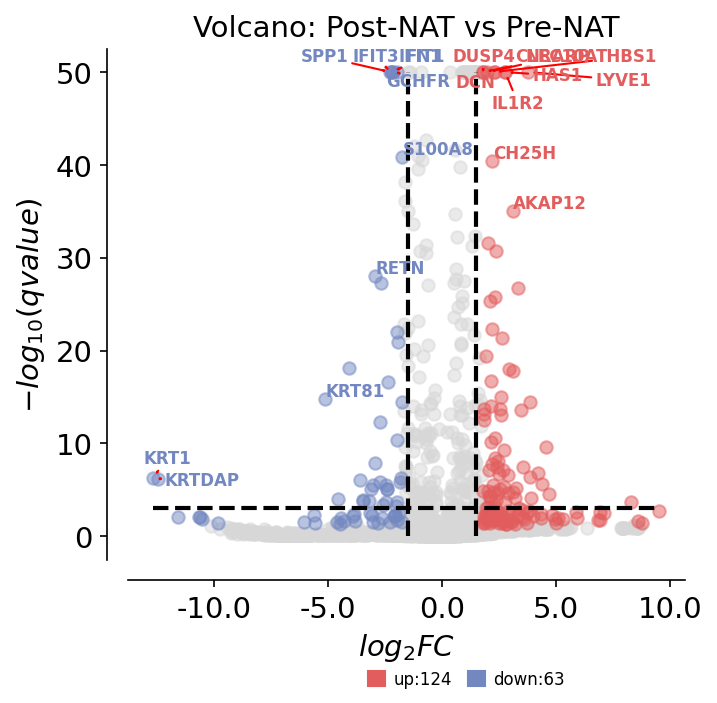

In [8]:
import numpy as np
import pandas as pd

# —— 1) 拷贝并确保基因是索引（若你的基因在第一列而非索引，解除注释下一行）
# deg_result = deg_result.set_index(deg_result.columns[0])

df = deg_result.copy()

# —— 2) 列类型转为数值；把非数字（比如 'nan' 字符串）变成 NaN
for col in ['qvalue', 'log2FC']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# —— 3) 关键：给 qvalue 设置极小正下限，避免 -log10(0) = inf
# 用 float64 能表示的最小正数；也可以改成 1e-300
# eps = np.nextafter(0, 1)
# df['qvalue'] = df['qvalue'].clip(lower=eps)
# 给 qvalue 设下限，保证 -log10(qvalue) ≤ 50
df['qvalue'] = df['qvalue'].clip(lower=10**-50)

# —— 4) 把其余无穷大/无穷小替换成 NaN，再丢弃会影响坐标的行
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna(subset=['qvalue', 'log2FC'])

# # —— 5) 如果还保留了你自己算的 -log 列，也把 inf 压到有限值，避免后续使用时报错
# for col in ['-log(pvalue)', '-log(qvalue)']:
#     if col in df.columns:
#         finite_mask = np.isfinite(df[col])
#         if (~finite_mask).any() and finite_mask.any():
#             df.loc[~finite_mask, col] = df.loc[finite_mask, col].max() + 1

# —— 5) 如果还保留了你自己算的 -log 列，把 inf 压到上限 50
for col in ['-log(pvalue)', '-log(qvalue)']:
    if col in df.columns:
        # 将 inf / -inf 替换为 NaN
        df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
        # 再用 clip 限制最大值为 50
        df[col] = df[col].clip(upper=50)

# —— 6) 只标注“清洗后仍存在且坐标有限”的基因，避免为无效点加注释
plot_genes = []
for g in selected_genes:
    if g in df.index:
        qv = df.at[g, 'qvalue']
        fc = df.at[g, 'log2FC']
        if np.isfinite(qv) and np.isfinite(fc) and (qv > 0):
            plot_genes.append(g)

print(f"After cleaning: {df.shape[0]} rows; labeling {len(plot_genes)} genes.")

# —— 7) 正式绘图：一定要把 result=df（清洗后的表），并传入原始 qvalue
import matplotlib.pyplot as plt
import omicverse as ov

fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
grp1, grp2 = 'Post-NAT', 'Pre-NAT'

ov.pl.volcano(
    result=df,
    pval_name='qvalue',      # 传原始 qvalue，函数内部会做 -log10
    fc_name='log2FC',
    pval_max=None,
    FC_max=None,
    figsize=(5, 5),
    title=f'Volcano: {grp1} vs {grp2}',
    titlefont={'weight': 'normal', 'size': 14},
    up_color='#e25d5d',
    down_color='#7388c1',
    normal_color='#d7d7d7',
    up_fontcolor='#e25d5d',
    down_fontcolor='#7388c1',
    normal_fontcolor='#d7d7d7',
    legend_bbox=(0.8, -0.2),
    legend_ncol=2,
    legend_fontsize=8,
    # 阈值
    pval_threshold=0.001,
    fc_max=1.5,               # 注意这里是 fc_max（小写）
    # 标注
    plot_genes=plot_genes,
    plot_genes_num=len(plot_genes),
    plot_genes_fontsize=8,
    ticks_fontsize=8,
    ax=ax
)

plt.tight_layout()
plt.savefig("figures/Mye_After_Before_DEG.svg", bbox_inches='tight')
plt.show()


#### 通路富集

In [1]:
import gseapy as gp
from gseapy import Msigdb
msig = Msigdb()
gmt = msig.get_gmt(category='mh.all', dbver="2024.1.Hs")
gmt

In [6]:
sc.tl.rank_genes_groups(adata_Mye, groupby = 'treat', method = 'wilcoxon')

NameError: name 'sc' is not defined

In [ ]:
# get deg result
result = adata_Mye.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names','scores', 'pvals','pvals_adj','logfoldchanges']})
degs

NameError: name 'adata_Mye' is not defined

In [ ]:
# subset up or down regulated genes
degs_sig = degs[degs.After_pvals_adj < 0.05]
degs_up = degs_sig[degs_sig.After_logfoldchanges > 0]
degs_dw = degs_sig[degs_sig.After_logfoldchanges < 0]

In [ ]:
degs_up

After_names  After_scores    After_pvals  After_pvals_adj  \
0            TPT1     28.456713  4.024939e-178    1.679728e-173   
1          GPR183     28.237507  2.026466e-175    4.228525e-171   
2          EEF1A1     27.067110  2.402536e-161    2.005300e-157   
3            CST3     26.836449  1.214105e-158    8.444707e-155   
4            JUND     23.855993  8.775173e-126    4.069048e-122   
...           ...           ...            ...              ...   
972       FAM168B      2.915855   3.547153e-03     4.820363e-02   
973         STK24      2.913007   3.579663e-03     4.856635e-02   
974     LINC01678      2.910467   3.608892e-03     4.889932e-02   
975        METTL9      2.902991   3.696173e-03     4.996837e-02   
39795      FRMD4A     -3.108578   1.879897e-03     2.747941e-02   

       After_logfoldchanges     Before_names  Before_scores   Before_pvals  \
0                  0.672479              FN1      34.415466  1.480345e-259   
1                  1.705157             SPP1      31.587706  5.446553e-219   
2                  0.657219           LGALS1      28.520657  6.495959e-179   
3                  0.851912             CTSD      28.150928  2.334541e-174   
4                  0.935975           DYNLL1      27.517467  1.085126e-166   
...                     ...              ...            ...            ...   
972                0.431335            PTPRA       8.453096   2.836779e-17   
973                0.224653             EID1       8.448258   2.956808e-17   
974                0.574773          HTATIP2       8.440072   3.171426e-17   
975                0.178648            TPRKB       8.439643   3.183077e-17   
39795              0.023952  ENSG00000249624      -0.333239   7.389539e-01   

       Before_pvals_adj  Before_logfoldchanges     Normal_names  \
0         3.088962e-255               1.816329             TPT1   
1         7.576699e-215               1.904949             EIF1   
2         4.518264e-175               0.809904            CEBPD   
3         1.391820e-170               1.098333           HSPA1A   
4         5.660694e-163               0.737188             SRGN   
...                 ...                    ...              ...   
972        1.044901e-15               0.537394  ENSG00000274092   
973        1.088152e-15               0.217352            P2RY2   
974        1.166107e-15               0.395012           ZNF704   
975        1.169360e-15               0.381350              ALB   
39795      1.000000e+00              -2.242802           CXCL11   

       Normal_scores   Normal_pvals  Normal_pvals_adj  Normal_logfoldchanges  \
0          25.021940  3.528399e-138     2.103581e-134               0.955577   
1          19.263079   1.096601e-82      1.476272e-79               0.716049   
2          18.524094   1.320076e-76      1.343676e-73               1.538394   
3          17.517191   1.059271e-68      8.501258e-66               1.222537   
4          15.662154   2.744411e-55      1.431656e-52               0.731870   
...              ...            ...               ...                    ...   
972         0.383731   7.011782e-01      1.000000e+00               1.552985   
973         0.383327   7.014771e-01      1.000000e+00               1.125512   
974         0.382465   7.021163e-01      1.000000e+00               1.398409   
975         0.382390   7.021723e-01      1.000000e+00               3.129623   
39795      -5.368387   7.944403e-08      1.607095e-06              -7.002407   

      W/O Treat_names  W/O Treat_scores  W/O Treat_pvals  W/O Treat_pvals_adj  \
0                 MX1         33.938118    1.826343e-252        7.621876e-248   
1               HLA-B         31.918606    1.473784e-223        3.075270e-219   
2              IFITM1         31.604790    3.172993e-219        4.413951e-215   
3               STAT1         28.649635    1.619909e-180        1.690091e-176   
4            HLA-DRB5         28.060570    2.968291e-173        2.477514e-169   
...         

In [ ]:
enr_up = gp.enrichr(degs_up.After_names,
                    gene_sets='KEGG_2021_Human',
                    outdir=None)
cc_up = gp.enrichr(degs_up.After_names,
                    gene_sets='GO_Cellular_Component_2023',
                    outdir=None)
bp_up = gp.enrichr(degs_up.After_names,
                    gene_sets='GO_Biological_Process_2023',
                    outdir=None)
mf_up = gp.enrichr(degs_up.After_names,
                    gene_sets='GO_Molecular_Function_2023',
                    outdir=None)
hm_up = gp.enrichr(degs_up.After_names,
                    gene_sets='MSigDB_Hallmark_2020',
                    outdir=None)

In [42]:
enr_down = gp.enrichr(degs_dw.After_names,
                    gene_sets='KEGG_2021_Human',
                    outdir=None)
cc_down = gp.enrichr(degs_dw.After_names,
                    gene_sets='GO_Cellular_Component_2023',
                    outdir=None)
bp_down = gp.enrichr(degs_dw.After_names,
                    gene_sets='GO_Biological_Process_2023',
                    outdir=None)
mf_down = gp.enrichr(degs_dw.After_names,
                    gene_sets='GO_Molecular_Function_2023',
                    outdir=None)
hm_down = gp.enrichr(degs_dw.After_names,
                    gene_sets='MSigDB_Hallmark_2020',
                    outdir=None)

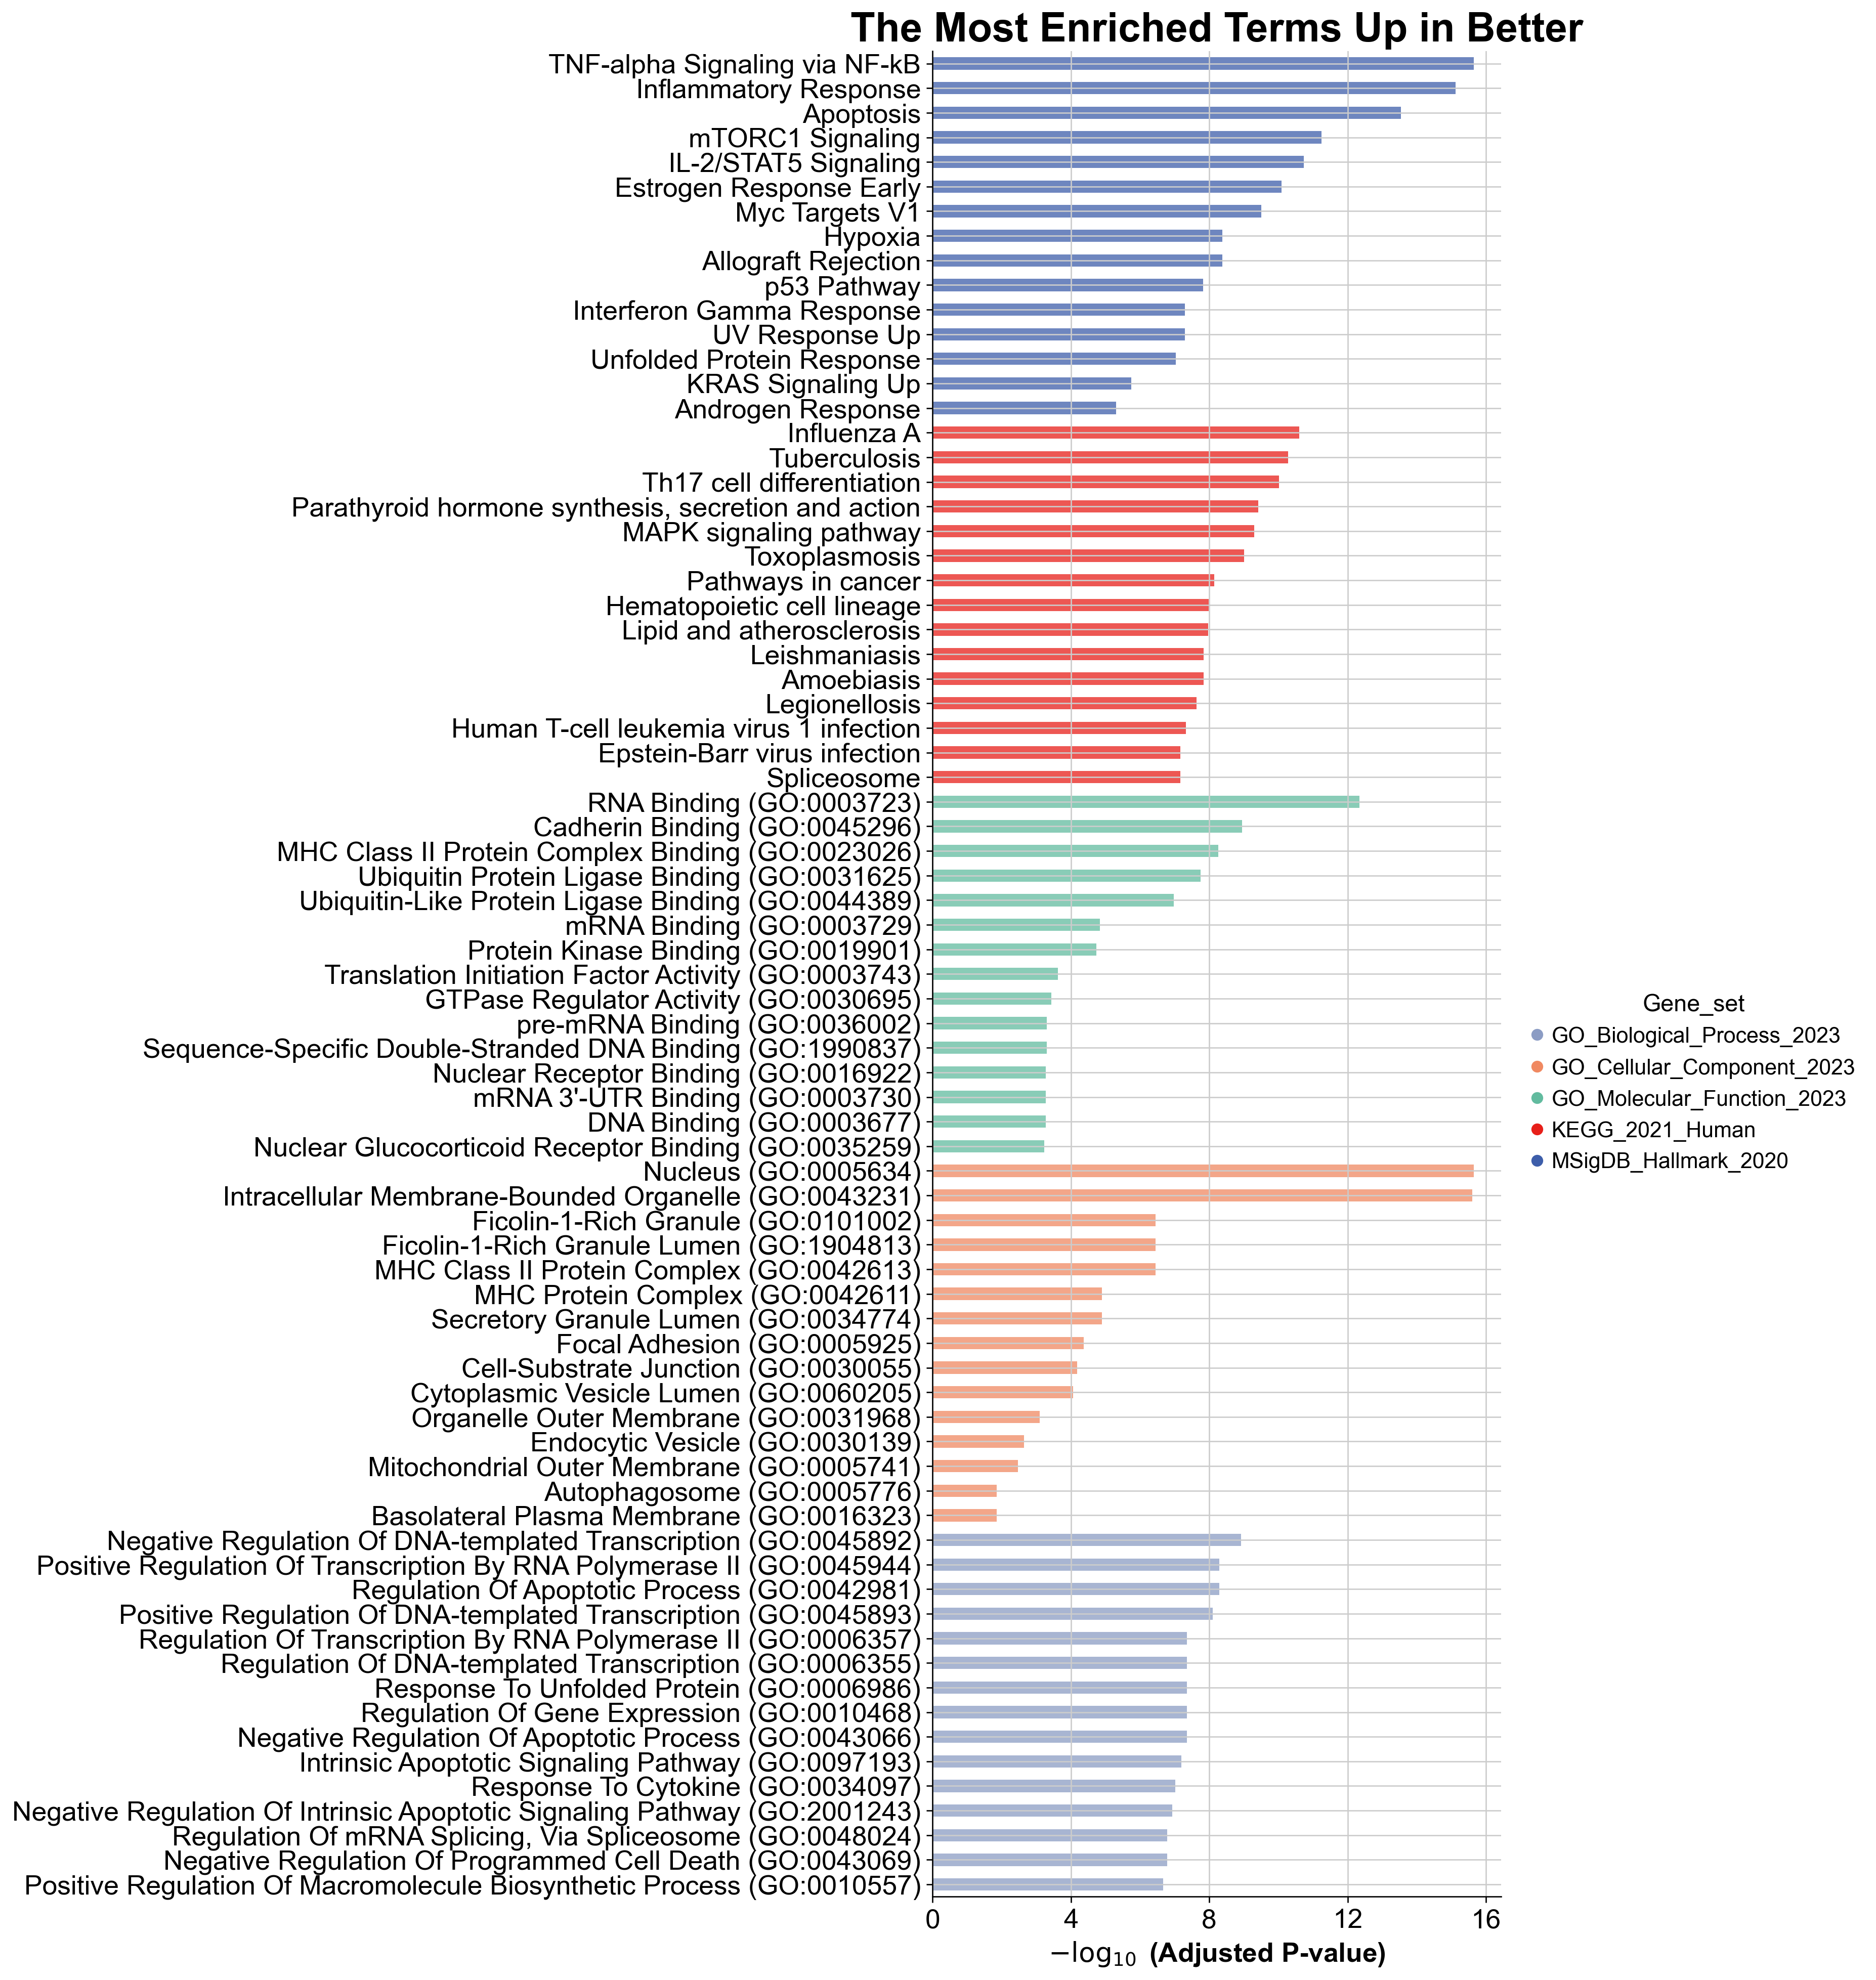

In [ ]:
go_res = pd.concat([enr_up.res2d.head(15),hm_up.res2d.head(15), cc_up.res2d.head(15), bp_up.res2d.head(15), mf_up.res2d.head(15)])
ax = gp.barplot(go_res, figsize=(6,20),
                group ='Gene_set',
                top_term=15,
                color = ['#8b9cc4', '#f08961', '#62bb9f', '#e71f19', '#3d5eaa'],
                title ="The Most Enriched Terms Up in Better")
ax.figure.savefig(f"figures/Myeloid_After_Enrichment_UP.svg")

In [44]:
def prep_enrichr(adata, groupby):
  # de analysis
  sc.tl.rank_genes_groups(adata, groupby=groupby)
  sc.tl.dendrogram(adata, groupby=groupby)
  # get deg result
  result = adata.uns['rank_genes_groups']
  groups = result['names'].dtype.names
  degs = pd.DataFrame(
      {group + '_' + key: result[key][group]
      for group in groups for key in ['names','scores', 'pvals','pvals_adj','logfoldchanges']})
  return degs

def run_enrichr_genelist(genelist):
  kegg = gp.enrichr(genelist,
                  gene_sets='KEGG_2021_Human',
                  outdir=None)
  cc = gp.enrichr(genelist,
                      gene_sets='GO_Cellular_Component_2023',
                      outdir=None)
  hm = gp.enrichr(genelist,
                      gene_sets=['MSigDB_Hallmark_2020'],
                      outdir=None)
  mf = gp.enrichr(genelist,
                      gene_sets='GO_Molecular_Function_2023',
                      outdir=None)
  bp = gp.enrichr(genelist,
                      gene_sets=['GO_Biological_Process_2023'],
                      outdir=None)
  return kegg, cc, hm, mf, bp

def run_enrichr_scanpy(degs, group,direction='up', top_term=15, all_term=False, plot=True):
  # subset up or down regulated genes
  degs_sig = degs[degs[f'{group}_pvals_adj'] < 0.05]
  degs_up = degs_sig[degs_sig[f'{group}_logfoldchanges'] > 0]
  degs_dw = degs_sig[degs_sig[f'{group}_logfoldchanges'] < 0]
  degs_used = degs_up[f'{group}_names'] if direction == 'up' else degs_dw[f'{group}_names']
  kegg, cc, hm, mf, bp = run_enrichr_genelist(degs_used)
  go_res = pd.concat([kegg.res2d.head(top_term),
                    hm.res2d.head(top_term), 
                    cc.res2d.head(top_term), 
                    bp.res2d.head(top_term), 
                    mf.res2d.head(top_term)])
  if plot:
    ax = gp.barplot(go_res, figsize=(6,20),
                group ='Gene_set',
                top_term=top_term,
                color = ['#8b9cc4', '#f08961', '#62bb9f', '#e71f19', '#3d5eaa'],
                title ="The Most Enriched Terms")
  else:
    ax = None
  if all_term:
    go_res = pd.concat([kegg.res2d, hm.res2d, cc.res2d, bp.res2d, mf.res2d])
  return go_res, ax
  
def run_enrichr_memento(memento_results,direction='up', top_term=15):
  memento_sig = memento_results[memento_results['de_pval'] < 0.05]
  memento_up = memento_sig[memento_sig['de_coef'] > 0]
  memento_dw = memento_sig[memento_sig['de_coef'] < 0]
  degs_used = memento_up['gene'] if direction == 'up' else memento_dw['gene']
  kegg, cc, hm, mf, bp = run_enrichr_genelist(degs_used)
  go_res = pd.concat([kegg.res2d.head(15),
                      hm.res2d.head(15), 
                      cc.res2d.head(15), 
                      bp.res2d.head(15), 
                      mf.res2d.head(15)])
  ax = gp.barplot(go_res, figsize=(6,20),
              group ='Gene_set',
              top_term=top_term,
              color = ['#8b9cc4', '#f08961', '#62bb9f', '#e71f19', '#3d5eaa'],
              title ="The Most Enriched Terms")
  return go_res, ax

In [ ]:
def HallMarkPlot(adata, anno, left, right, ct, left_label='Pre-ICI', right_label='Post-ICI', title=None):
  degs_pre = prep_enrichr(adata[adata.obs['treat'].isin(left)], anno)
  degs_post = prep_enrichr(adata[adata.obs['treat'].isin(right) ], anno)
  print(f"Running enrichment for {left_label} {ct}...")
  go_pre, _ = run_enrichr_scanpy(degs_pre, ct,direction='up', top_term=15, all_term=True, plot=False)
  go_pre =  go_pre[['Gene_set', 'Term', 'Overlap', 'P-value', 'Adjusted P-value', 'Odds Ratio', 'Combined Score']]
  go_pre['anno'] = ct
  go_pre['treat'] = 'left'

  print(f"Running enrichment for {right_label} {ct}...")
  go_post, _ = run_enrichr_scanpy(degs_post, ct,direction='up', top_term=15, all_term=True, plot=False)
  go_post = go_post[['Gene_set', 'Term', 'Overlap', 'P-value', 'Adjusted P-value', 'Odds Ratio', 'Combined Score']]
  go_post['anno'] = ct
  go_post['treat'] = 'right'

  left_pathway = go_pre[go_pre['Gene_set'].isin(['MSigDB_Hallmark_2020'])][:10]['Term']
  right_pathway = go_post[go_post['Gene_set'].isin(['MSigDB_Hallmark_2020'])][:10]['Term']
  pathway = list(set(list(left_pathway)).intersection(list(right_pathway)))

  use_pathway_left = go_pre[go_pre['Gene_set'].isin(['MSigDB_Hallmark_2020'])]
  use_pathway_right = go_post[go_post['Gene_set'].isin(['MSigDB_Hallmark_2020'])]

  use_pathway_left = use_pathway_left[use_pathway_left['Term'].isin(left_pathway)]
  use_pathway_right = use_pathway_right[use_pathway_right['Term'].isin(right_pathway)]
  use_pathway = pd.concat([use_pathway_left, use_pathway_right], axis=0)
  ax = gp.dotplot(use_pathway,figsize=(2,5),
                x='treatment',
                title="",
                size=2.5,
                cmap='viridis',
                top_term=10,
                show_ring=True)
  ax.set_xticklabels(['Pre-ICI', 'Post-ICI'],rotation=0)
  ax.set_yticklabels(ax.get_yticklabels(),rotation=0,fontsize=11)
  ax.set_xlabel('')
  if title is None:
    ax.set_title(ct)
  else:
    ax.set_title(title)
  ax.figure.savefig(f"{figPath}/Hallmark_{ct}.svg", bbox_inches='tight')
  return use_pathway, ax

In [49]:
use_pathway_pTex, ax_pTex = HallMarkPlot(adata_Mye, 'anno-Mye', ['Before', 'W/O Treat'], [' After'], 'M01_Mac1_SPP1', title='Mac1_SPP1')

AttributeError: 'NoneType' object has no attribute 'columns'

In [5]:
import memento
import anndata as ad
import pandas as pd
def DE_memento_1d(adata: ad.AnnData, ctleft: list, ctright: list, groupby='annotation'):
  """
  使用 Memento 包分析单细胞测序数据中的动态变化。

  Args:
      adata (ad.AnnData): 单细胞测序数据的 AnnData 对象,adata.X requires raw data。
      ctleft (list): 左条件列表，表示刺激前的细胞类型或状态。
      ctright (list): 右条件列表，表示刺激后的细胞类型或状态。
      groupby (str, optional): 用于分组的注释列名。默认为 'annotation'。

  Returns:
      pd.DataFrame: Memento 分析的结果，包括差异表达分析、HT 1D moments 分析等。

  """
  _adata = adata[adata.obs[groupby].isin(ctleft + ctright)].copy()
  _adata = ad.AnnData(_adata.X, obs = _adata.obs, var = _adata.var)
  _adata.obs['stim'] = _adata.obs[groupby].isin(ctright)
  _adata.obs['stim'] = _adata.obs['stim'].astype('int')
  _adata.obs['capture_rate'] = 0.07
  memento.setup_memento(_adata, q_column='capture_rate')
  memento.create_groups(_adata, label_columns=['stim'])
  memento.compute_1d_moments(_adata, min_perc_group=.7)
  meta_df = memento.get_groups(_adata)
  meta_df['intercept'] = 1
  convariate = meta_df[['intercept']]
  treatment = (meta_df[['stim']] == 1).astype(float)
  
  memento.ht_1d_moments(_adata,
  covariate=convariate,
  treatment=treatment,
  num_cpus=16,
  resample_rep=False,
  )
  memento_results = memento.get_1d_ht_result(_adata)
  return(memento_results)

import scanpy as sc
import gseapy as gp
from gseapy import Msigdb
def prep_enrichr(adata, groupby):
  # de analysis
  sc.tl.rank_genes_groups(adata, groupby=groupby)
  sc.tl.dendrogram(adata, groupby=groupby)
  # get deg result
  result = adata.uns['rank_genes_groups']
  groups = result['names'].dtype.names
  degs = pd.DataFrame(
      {group + '_' + key: result[key][group]
      for group in groups for key in ['names','scores', 'pvals','pvals_adj','logfoldchanges']})
  return degs

def run_enrichr_genelist(genelist):
  kegg = gp.enrichr(genelist,
                  gene_sets='KEGG_2021_Human',
                  outdir=None)
  cc = gp.enrichr(genelist,
                      gene_sets='GO_Cellular_Component_2023',
                      outdir=None)
  hm = gp.enrichr(genelist,
                      gene_sets=['MSigDB_Hallmark_2020'],
                      outdir=None)
  mf = gp.enrichr(genelist,
                      gene_sets='GO_Molecular_Function_2023',
                      outdir=None)
  bp = gp.enrichr(genelist,
                      gene_sets=['GO_Biological_Process_2023'],
                      outdir=None)
  return kegg, cc, hm, mf, bp

def run_enrichr_scanpy(degs, group,direction='up', top_term=15, all_term=False, plot=True, threshold=0.5):
  # subset up or down regulated genes
  degs_sig = degs[degs[f'{group}_pvals_adj'] < 0.05]
  degs_up = degs_sig[degs_sig[f'{group}_logfoldchanges'] > threshold]
  degs_dw = degs_sig[degs_sig[f'{group}_logfoldchanges'] < -threshold]
  degs_used = degs_up[f'{group}_names'] if direction == 'up' else degs_dw[f'{group}_names']
  kegg, cc, hm, mf, bp = run_enrichr_genelist(degs_used)
  go_res = pd.concat([kegg.res2d.head(top_term),
                    hm.res2d.head(top_term), 
                    cc.res2d.head(top_term), 
                    bp.res2d.head(top_term), 
                    mf.res2d.head(top_term)])
  if plot:
    ax = gp.barplot(go_res, figsize=(6,20),
                group ='Gene_set',
                top_term=top_term,
                color = ['#8b9cc4', '#f08961', '#62bb9f', '#e71f19', '#3d5eaa'],
                title ="The Most Enriched Terms")
  else:
    ax = None
  if all_term:
    go_res = pd.concat([kegg.res2d, hm.res2d, cc.res2d, bp.res2d, mf.res2d])
  return go_res, ax
  
def run_enrichr_memento(memento_results,direction='up', top_term=15):
  memento_sig = memento_results[memento_results['de_pval'] < 0.05]
  memento_up = memento_sig[memento_sig['de_coef'] > 0]
  memento_dw = memento_sig[memento_sig['de_coef'] < 0]
  degs_used = memento_up['gene'] if direction == 'up' else memento_dw['gene']
  kegg, cc, hm, mf, bp = run_enrichr_genelist(degs_used)
  go_res = pd.concat([kegg.res2d.head(15),
                      hm.res2d.head(15), 
                      cc.res2d.head(15), 
                      bp.res2d.head(15), 
                      mf.res2d.head(15)])
  ax = gp.barplot(go_res, figsize=(6,20),
              group ='Gene_set',
              top_term=top_term,
              color = ['#8b9cc4', '#f08961', '#62bb9f', '#e71f19', '#3d5eaa'],
              title ="The Most Enriched Terms")
  return go_res, ax

In [6]:
degs = prep_enrichr(adata_Mye, "treat")

In [8]:
gores_list = []
cell_types = ['After', 'Before', 'W/O Treat']
for ct in cell_types:
  print("Running enrichment for {}...".format(ct))
  go_res, _ = run_enrichr_scanpy(degs, ct,direction='up', top_term=15, all_term=True, plot=False)
  go_res = go_res =  go_res[['Gene_set', 'Term', 'Overlap', 'P-value', 'Adjusted P-value', 'Odds Ratio', 'Combined Score']]
  go_res['anno'] = ct
  gores_list.append(go_res)
gores = pd.concat(gores_list, axis=0, ignore_index=True)


Running enrichment for After...


Running enrichment for Before...
Running enrichment for W/O Treat...


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

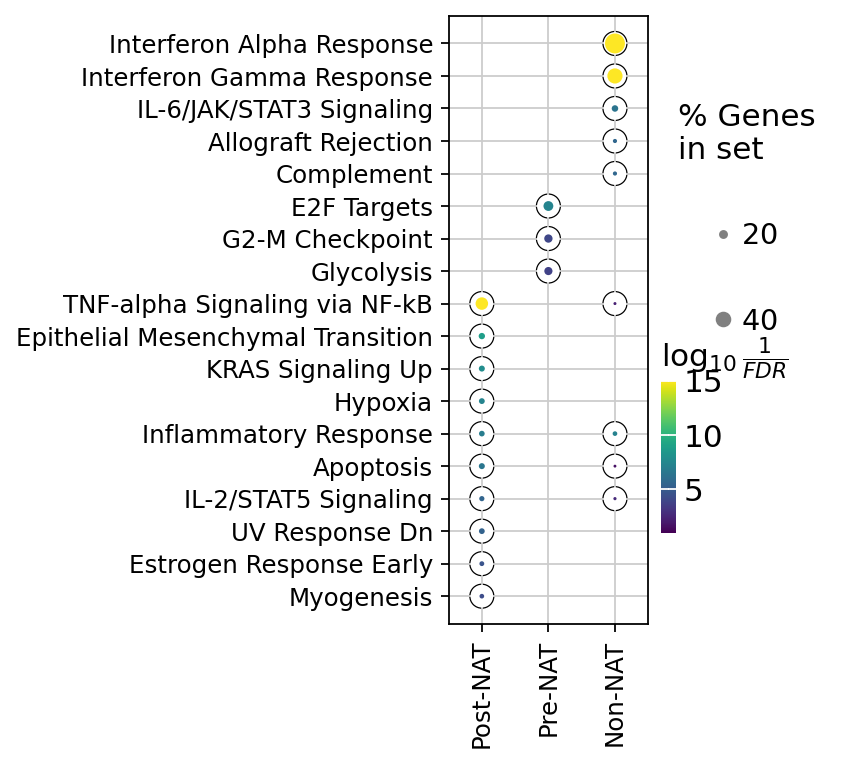

In [9]:
from gseapy.scipalette import SciPalette
sci = SciPalette()
NbDr = sci.create_colormap() 
ax = gp.dotplot(gores[gores['Gene_set'].isin(['MSigDB_Hallmark_2020'])],figsize=(2,5),
                x='anno',
                title="",
                size=2.5,
                cmap='viridis',
                top_term=10,
                show_ring=True)
ax.set_xticklabels(['Post-NAT', 'Pre-NAT', 'Non-NAT'],rotation=90, fontsize=11)
ax.set_yticklabels(ax.get_yticklabels(),rotation=0, fontsize=11)
ax.set_xlabel('')
ax.figure.savefig("figures/Mye_MSigDB_Hallmark_2020.svg", bbox_inches='tight')